## Creating a SoftMax Neural Net from Scratch

In [77]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import plotly
import plotly.graph_objects as go
import plotly.express as px

In [78]:
#Load the data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train, x_test, y_test = x_train.astype('int'), y_train.astype('int'), x_test.astype('int'), y_test.astype('int')

In [79]:
#Data preparation section

def create_one_hot_train_and_test(y_train, y_test):
    one_hot = OneHotEncoder(sparse = False)
    one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1)).T ###currently doing it on two classes
    one_hot_y_test = one_hot.fit_transform(y_test.reshape(-1,1)).T
    return one_hot_y_train, one_hot_y_test

def flatten_and_normalise_x_values(x_train, x_test):
    x_train_flat = x_train.reshape((x_train.shape[0],-1)).T / 255
    x_test_flat = x_test.reshape((x_test.shape[0],-1)).T / 255
    return x_train_flat, x_test_flat

In [80]:
x_train_flat, x_test_flat = flatten_and_normalise_x_values(x_train,x_test)
one_hot_y_train, one_hot_y_test = create_one_hot_train_and_test(y_train, y_test)

In [192]:
class Neural_Net_Softmax():
    
    #Initialise with the input shape and output shape
    def __init__(self, input_features, output_features):
        self.input_dimension = input_features
        self.output_dimensions = output_features
        #Initialise the dictionaries here so we can't accidentally store values we don't need if we change the input sizes.
        self.fp_dict = {}
        self.weights = {}
        self.bp_dict = {}

    def create_layers(self,array_of_mid_layer_sizes, activation_functions = 'relu'):
        self.mid_layer_sizes = array_of_mid_layer_sizes        
        
        #for layer type, we can either set all layers to one type or have an array of layers passed
        if activation_functions in ('relu', 'sigmoid'):
            self.mid_layer_types = [activation_functions] * len(array_of_mid_layer_sizes)
        else:
            self.mid_layer_types = activation_functions
        self.fp_rounds = len(array_of_mid_layer_sizes) + 1 #Define this here as will be used a lot later and creates one terminology
        self.all_layers = [self.input_dimension] + self.mid_layer_sizes + [self.output_dimensions] #

    def init_weights(self, init_methods='gaussian'):
        #Allow either a list of init_methods or one init method for all layers
        if type(init_methods) == str:
            init_methods = [init_methods] * self.fp_rounds #This creates a list of layers-1 weight initialisation strings.
        
        #this iterates through the size of layer and the init methods
        for layer, init_method in zip(range(self.fp_rounds),init_methods):
            output_dim = self.all_layers[layer+1]
            input_dim = self.all_layers[layer] 

            #Use locals to call the reelvant function
            self.weights[f'W{layer+1}'], self.weights[f'B{layer+1}'] = globals()[f'_{init_method}_init'](output_dim, input_dim)
            #Then create a bp Dict of the same proportions but all 0s
            self.bp_dict[f'dW{layer+1}'], self.bp_dict[f'dB{layer+1}'] = globals()[f'_{init_method}_init'](output_dim, input_dim)
            self.bp_dict[f'dW{layer+1}'] *= 0 #then set them to 0 as they are used in the first iteration
            self.bp_dict[f'dB{layer+1}'] *= 0
    
    def forward_prop(self, x_flat, one_hot_y):
        self.fp_dict['A0'], self.fp_dict['Z0'] = x_flat, 0 #We create Z0 because need to call it later, even though we use an if statement not to actually use it.
        fp_rounds = self.fp_rounds

        #First, do all the layers up to thte softmax layer ,which has a different activation function.
        for key, activation_function in zip(range(1,fp_rounds),self.mid_layer_types): #starts at 1, goes up to the last hidden layer
            activation = globals()[f'_{activation_function}_fp']
            self.fp_dict[f'Z{key}'], self.fp_dict[f'A{key}'] = activation(self.fp_dict[f'A{key-1}'], self.weights[f'W{key}'], self.weights[f'B{key}'])

        #Then do the final layer and calculate cost
        self.fp_dict[f'Z{fp_rounds}'], self.fp_dict[f'A{fp_rounds}'] = _last_leg_softmax(self.fp_dict[f'A{fp_rounds-1}'], self.weights[f'W{fp_rounds}'], self.weights[f'B{fp_rounds}']) 
        cost = -np.sum(one_hot_y * np.log(self.fp_dict[f'A{fp_rounds}'])) / one_hot_y.shape[1] #divides by training examples
        return self.fp_dict, cost

    def back_prop(self, x_flat, one_hot_y, grad_update_lag = 0.8):
        ZA_dict = {} #this is a temporary dict to store values that are needed at later stages of back prop.
        ZA_dict['Z0'] = {} #Just useful for iterations.
        
        #The first dC_dZ is the classic Softmax function, ÿ - y
        ZA_dict[f'dC_dZ{self.fp_rounds}'] = self.fp_dict[f'A{self.fp_rounds}'] - one_hot_y
        
        #Then we need to iterate back across all layers, getting the relevant dw's for grad descent and the dZs for the previous layer        
        final_layer_code = 'no' #this is to solve the issue of the last layer not having Z values
        for key, activation in zip(reversed(range(1,self.fp_rounds+1)),self.mid_layer_types):
            if key == 1: #this is needed because it stops the function using z_min_1 as a calculation, which would throw an error because it's blank.
                final_layer_code = 'yes' 
            dW_temp_var, dB_temp_var, ZA_dict[f'dC_dZ{key-1}'] = back_prop_from_z_to_z(ZA_dict[f'dC_dZ{key}'], final_layer_code, self.fp_dict[f'Z{key-1}'], self.fp_dict[f'A{key-1}'], self.weights[f'W{key}'],activation=activation)            
            #Allow learning rate smoothing
            self.bp_dict[f'dW{key}'] = grad_update_lag * self.bp_dict[f'dW{key}'] + (1-grad_update_lag) * dW_temp_var
            self.bp_dict[f'dB{key}'] = grad_update_lag * self.bp_dict[f'dB{key}'] + (1-grad_update_lag) * dB_temp_var

    def gradient_descent(self, learning_rate):
        for key, value in self.weights.items():
            self.weights[key] += -learning_rate * self.bp_dict[f'd{key}']


    def model_learn(self, x_flat, y_train, epochs, batches = 1, learning_rate=0.03, grad_update_lag = 0.8):
        #Prepare Y in the right form here.
        
        one_hot = OneHotEncoder(sparse = False)
        one_hot_y= one_hot.fit_transform(y_train.reshape(-1,1)).T ##currently doing it on two classes
        cost_log = []
        for epoch in range(epochs):
            batch_size = int(x_flat.shape[1]//batches)
            #This sections deals with batching
            round_ = epoch % batches
            if round_ == 0:
                n, k = 0, batch_size
            else:
                n, k = batch_size*round_, batch_size*(1 + round_)
            self.fp_dict, cost = self.forward_prop(x_flat[:,n:k], one_hot_y[:,n:k])
            cost_log.append(cost)
            self.back_prop(x_flat[:,n:k], one_hot_y[:,n:k], grad_update_lag = grad_update_lag)
            self.gradient_descent(learning_rate = learning_rate)
        prediction_accuracy, lop = self.predict(x_flat, y_train, one_hot_y)
            
        return prediction_accuracy, cost_log
            
    def predict(self, x, y, one_hot_y):
        y_reshaped = y.reshape(1,-1)
        fp_predict_dict, cost = self.forward_prop(x, one_hot_y) 
        y_hat_softmax_form = fp_predict_dict[f'A{self.fp_rounds}'].T
        list_of_predictions = []
        #Each rows is one trainign example (because it's transposed)
        for row in y_hat_softmax_form:
            max = np.amax(row) #get max value from each row
            for idx,col in enumerate(row):
                if col == max: #append the idx number that has that max value to a list, to create predictions
                    list_of_predictions.append(idx)
                    break
    
        table_preds = pd.DataFrame({'predictions': list_of_predictions, 'actuals':y_reshaped[0]})
        table_preds['Correct'] = table_preds['predictions'] - table_preds['actuals']
        table_preds['Correct'] = table_preds['Correct'].apply(lambda x: 1 if x == 0 else 0)
        Correct_Percentage = np.sum(table_preds['Correct']) / len(table_preds)
        return Correct_Percentage, list_of_predictions



'''Helper functions - outside of class so they can be called with globals'''

    
#weights initialisati"ons
def _gaussian_init(output_dim, input_dim):
    W, B = np.random.randn(output_dim,input_dim), np.random.randn(output_dim,1)
    return W,B
def _xavier_init(output_dim,input_dim):
    W, B = np.random.uniform(-np.sqrt(6)/(np.sqrt(output_dim+input_dim)),np.sqrt(6)/(np.sqrt(output_dim+input_dim)),[output_dim,input_dim]), np.random.uniform(-np.sqrt(6)/(np.sqrt(output_dim+1)),np.sqrt(6)/(np.sqrt(output_dim+1)),[output_dim,1])
    return W,B
#add relu     

#forward props
def _sigmoid(x):
    return (1/(1+np.exp(-x)))
def _sigmoid_fp(prev_a, W, B):
    Z = W @ prev_a + B
    return Z, _sigmoid(Z)    
def _relu(Z):
    return np.maximum(Z,np.zeros_like(Z))
def _relu_fp(prev_a, W, B):
    Z = W @ prev_a + B
    return Z, _relu(Z)
def _last_leg_softmax(previous_a, W, B):
    Z = W @ previous_a + B
    A = np.exp(Z)
    A = A / np.sum(A,axis=0) 
    return Z, A   

## BACK PROPOGATION 
def back_prop_from_z_to_z(dC_dZn, final_layer_or_not,prev_Z, prev_A,W,activation='sigmoid'):    

    #get diffs at that layer
    dZn_dWn = prev_A
    dZn_dBn = np.zeros_like(dC_dZn) + 1 #output feature x training examples
    #combien to get useful differentials
    dC_dWn = dC_dZn @ dZn_dWn.T / dC_dZn.shape[1] #training examples
    dC_dBn = np.sum(dC_dZn @ dZn_dBn.T,axis=1,keepdims=True) / dZn_dBn.size ###THIS COULD BE WRONG, MIGHT BE SHAPE. let's try both. BUT IT LOOKS like this is creating a column created from mxmx10, which is size.

    #and then get the previous layer cost fuctions
    if final_layer_or_not == 'no':
        dZn_dA_minus_one = W
        dC__dA_minus_one = (dC_dZn.T @ dZn_dA_minus_one).T
        if activation=='sigmoid':
            dAn_minus_one__dZ_minus_one = np.exp(-prev_Z) / ((1+np.exp(-prev_Z))**2)  #sigmoid differentiated
        elif activation=='relu':
            dAn_minus_one__dZ_minus_one=np.where(prev_Z < 0, 0, 1)
        dC__dZ_minus_one = dC__dA_minus_one * dAn_minus_one__dZ_minus_one
        return dC_dWn, dC_dBn, dC__dZ_minus_one
    else:
        return dC_dWn, dC_dBn, 0

In [218]:
#Initialise the model
nn_test = Neural_Net_Softmax(784, 10)
nn_test.create_layers([200,200,100,100], 'relu')
nn_test.init_weights('xavier')

In [219]:
#Train the model
epochs = 100000
preds_accuracy_test, test_cost_log = nn_test.model_learn(x_train_flat, y_train, epochs = epochs, batches = 1000, learning_rate=0.03, grad_update_lag = 0.9)


/Users/jacoblourie/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(0.9999833333333333, <AxesSubplot:>)

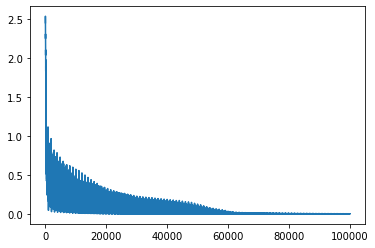

In [220]:
#print cost log and train set accuracy
preds_accuracy_test, sns.lineplot(np.linspace(1,epochs,epochs),test_cost_log)

Test set accuracy and cost

In [221]:
#predict the test set
lop = nn_test.predict(x_test_flat, y_test, one_hot_y_test)

In [222]:
#get test set accuracy
fdfd = pd.DataFrame({'predictions':np.array(lop[1]), 'true values': y_test})
fdfd['correct'] = fdfd['predictions'] - fdfd['true values']
display(pd.DataFrame(fdfd['correct'].value_counts(normalize=True).head(1)))

,correct
0,0.9689


In [217]:
#Plot histograms of the plots.
titles=list(nn_test.weights.keys())
print(nn_test.weights.keys())
rows = 2
cols = int(round(len(nn_test.fp_dict)/2)-1)
print(cols)
fig = plotly.subplots.make_subplots(rows=rows,cols=cols,subplot_titles=titles)
#create hists
list_of_plots = []
for key, value in nn_test.weights.items():
    list_of_plots.append(go.Histogram(x=value.flatten(),name=key,nbinsx=40))

#itereate through rows and columns and the list_of_plots
counter_for_plots = 0
for rowx in range(1,rows+1):
    for colx in range(1,cols+1):
        fig.add_trace(
        list_of_plots[counter_for_plots],
        row=rowx,col=colx,
        )
        counter_for_plots+=1

fig.update_layout(width=1500,height=1000)

fig.show()

dict_keys(['W1', 'B1', 'W2', 'B2', 'W3', 'B3', 'W4', 'B4', 'W5', 'B5'])
5
